<a href="https://colab.research.google.com/github/Kevangi/skin-cancer-classification/blob/main/HAM10000_DenseNet169.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kevangipatel","key":"abf434d588fdd6ab1de8e8b058632ee4"}'}

In [2]:
!ls

kaggle.json  sample_data


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets list | head

ref                                                             title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -----------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
saidaminsaidaxmadov/chocolate-sales                             Chocolate Sales                                      468320  2026-01-04 14:23:35.490000          13644        239  1.0              
emirhanakku/synthetic-healthcare-patient-journey-dataset        Synthetic Healthcare Patient Journey Dataset          38540  2026-02-02 21:18:38.177000            710         33  1.0              
aliiihussain/amazon-sales-dataset                               Amazon_Sales_Dataset                                1297759  2026-02-01 11:37:12.353000           1701         40  1.0              
ayeshaimran1619

In [5]:
!kaggle datasets download -d vrindaat/ham10000-dataset
!unzip ham10000-dataset.zip -d ham10000-dataset

Streaming output truncated to the last 5000 lines.
  inflating: ham10000-dataset/HAM10000_images_part_2/ISIC_0029322.jpg  
  inflating: ham10000-dataset/HAM10000_images_part_2/ISIC_0029323.jpg  
  inflating: ham10000-dataset/HAM10000_images_part_2/ISIC_0029324.jpg  
  inflating: ham10000-dataset/HAM10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000-dataset/HAM10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000-dataset/HAM10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000-dataset/HAM10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000-dataset/HAM10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000-dataset/HAM10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000-dataset/HAM10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000-dataset/HAM10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000-dataset/HAM10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000-dataset/HAM10000_images_part_2/ISIC_0029334.jpg  
  inflating: 

In [6]:
ls

ham10000-dataset/  ham10000-dataset.zip  kaggle.json  sample_data/


In [7]:
ls ham10000-dataset

HAM10000_images_part_1/  HAM10000_images_part_2/  HAM10000_metadata.csv


In [8]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [9]:
BASE_DIR = "/content/ham10000-dataset"
CSV_PATH = os.path.join(BASE_DIR, "HAM10000_metadata.csv")

IMG_DIR_1 = os.path.join(BASE_DIR, "HAM10000_images_part_1")
IMG_DIR_2 = os.path.join(BASE_DIR, "HAM10000_images_part_2")

IMG_SIZE = 224
BATCH_SIZE = 32

In [10]:
df = pd.read_csv(CSV_PATH)

label_mapping = {
    'mel': 0, 'nv': 1, 'bcc': 2,
    'akiec': 3, 'bkl': 4, 'df': 5, 'vasc': 6
}

df['label'] = df['dx'].map(label_mapping)

def get_image_path(image_id):
    p1 = os.path.join(IMG_DIR_1, image_id + ".jpg")
    p2 = os.path.join(IMG_DIR_2, image_id + ".jpg")
    return p1 if os.path.exists(p1) else p2

df['image_path'] = df['image_id'].apply(get_image_path)

In [11]:
train_df, temp_df = train_test_split(
    df, test_size=0.30, stratify=df['label'], random_state=42
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df['label'], random_state=42
)

In [12]:
class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

class_weights = {i: w for i, w in enumerate(class_weights_array)}

In [13]:
def dull_razor(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    return cv2.inpaint(image, mask, 1, cv2.INPAINT_TELEA)

In [14]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])

In [15]:
class HAM10000Generator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, augment=False, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_df = self.df.iloc[batch_idx]

        images, labels = [], []

        for _, row in batch_df.iterrows():
            img = cv2.imread(row['image_path'])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            img = dull_razor(img)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img.astype(np.float32) / 255.0
            img = (img - IMAGENET_MEAN) / IMAGENET_STD

            if self.augment:
                if np.random.rand() < 0.5:
                    img = np.fliplr(img)
                if np.random.rand() < 0.5:
                    img = np.flipud(img)

            images.append(img)
            labels.append(row['label'])

        return np.array(images), np.array(labels)

In [16]:
train_gen = HAM10000Generator(train_df, BATCH_SIZE, augment=True, shuffle=True)
val_gen   = HAM10000Generator(val_df,   BATCH_SIZE, augment=False, shuffle=False)
test_gen  = HAM10000Generator(test_df,  BATCH_SIZE, augment=False, shuffle=False)

In [17]:
base_model = DenseNet169(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(7, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [18]:
# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)

# Enable memory growth (VERY IMPORTANT)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No GPU found. Please enable GPU in Runtime settings.")

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Physical devices cannot be modified after being initialized


In [19]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 430s 2s/step - accuracy: 0.3568 - loss: 2.1090 - val_accuracy: 0.5200 - val_loss: 1.2668
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.5020 - loss: 1.3052 - val_accuracy: 0.5466 - val_loss: 1.2610
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - accuracy: 0.5567 - loss: 1.1828 - val_accuracy: 0.6125 - val_loss: 0.9871
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.5834 - loss: 1.0835 - val_accuracy: 0.6032 - val_loss: 1.0095
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 335s 2s/step - accuracy: 0.5635 - loss: 1.1267 - val_accuracy: 0.6478 - val_loss: 0.8943
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - accuracy: 0.5969 - loss: 1.0631 - val_accuracy: 0.6178 - val_loss: 0.9485
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.6316 - loss: 0.9491 - val_accuracy: 0.5925 - val_loss: 1.0137
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.6275 - loss: 0.9491 - val_accu

In [20]:
for layer in base_model.layers[int(len(base_model.layers)*0.7):]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(patience=3, factor=0.3)
    ]
)

Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step - accuracy: 0.5747 - loss: 1.1495 - val_accuracy: 0.6551 - val_loss: 0.8304 - learning_rate: 1.0000e-04
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.6676 - loss: 0.7394 - val_accuracy: 0.6791 - val_loss: 0.7912 - learning_rate: 1.0000e-04
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.7038 - loss: 0.5949 - val_accuracy: 0.7031 - val_loss: 0.7141 - learning_rate: 1.0000e-04
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.7295 - loss: 0.5403 - val_accuracy: 0.6944 - val_loss: 0.7565 - learning_rate: 1.0000e-04
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.7647 - loss: 0.4538 - val_accuracy: 0.7463 - val_loss: 0.6587 - learning_rate: 1.0000e-04
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.7803 - loss: 0.4161 - val_accuracy: 0.7197 - val_loss: 0.7523 - learning_rate: 1.0000e-04
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - acc

In [21]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test Accuracy:", test_acc)

47/47 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8022 - loss: 0.6089
Test Accuracy: 0.8077179193496704


In [22]:
print(f"Test Loss     : {test_loss:.4f}")

Test Loss     : 0.6035


In [23]:
# True labels
y_true = test_gen.df['label'].values

# Predicted probabilities
y_pred_probs = model.predict(test_gen)

# Predicted class labels
y_pred = np.argmax(y_pred_probs, axis=1)


47/47 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step


In [24]:
from sklearn.metrics import classification_report

class_names = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
))

              precision    recall  f1-score   support

         MEL     0.5705    0.5329    0.5511       167
          NV     0.9407    0.8837    0.9113      1006
         BCC     0.6977    0.7792    0.7362        77
       AKIEC     0.5263    0.6122    0.5660        49
         BKL     0.5450    0.6970    0.6117       165
          DF     0.5000    0.6471    0.5641        17
        VASC     0.7692    0.9091    0.8333        22

    accuracy                         0.8077      1503
   macro avg     0.6499    0.7230    0.6820      1503
weighted avg     0.8227    0.8077    0.8131      1503



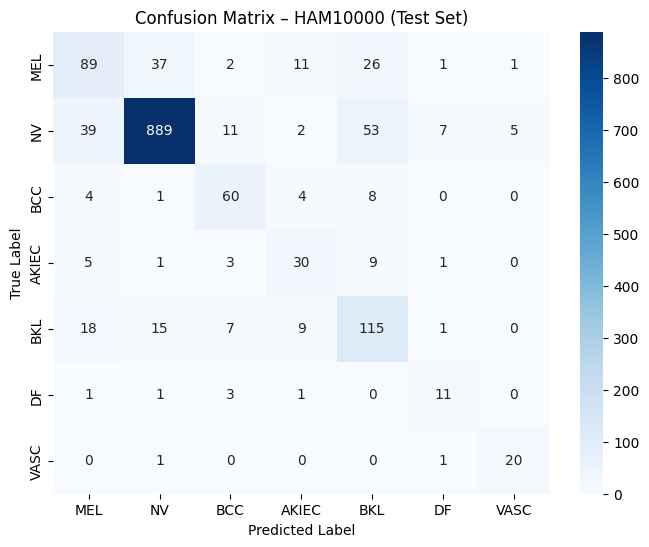

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – HAM10000 (Test Set)")
plt.show()

In [26]:
from sklearn.metrics import f1_score, precision_score, recall_score

macro_f1 = f1_score(y_true, y_pred, average="macro")
weighted_f1 = f1_scor
Weighted F1-score : 0.8131e(y_true, y_pred, average="weighted")

print(f"Macro F1-score    : {macro_f1:.4f}")
print(f"Weighted F1-score : {weighted_f1:.4f}")

Macro F1-score    : 0.6820
Weighted F1-score : 0.8131


In [27]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import to_categorical

y_true_oh = to_categorical(y_true, num_classes=7)

roc_auc = roc_auc_score(
    y_true_oh,
    y_pred_probs,
    average="macro",
    multi_class="ovr"
)

print(f"Macro ROC-AUC : {roc_auc:.4f}")

Macro ROC-AUC : 0.9544


In [28]:
macro_recall = recall_score(y_true, y_pred, average="macro")
weighted_recall = recall_score(y_true, y_pred, average="weighted")

In [29]:
print(f"Macro Recall         : {macro_recall:.4f}")
print(f"Weighted Recall      : {weighted_recall:.4f}")

Macro Recall         : 0.7230
Weighted Recall      : 0.8077


In [30]:
# Pick one test image
row = test_df.sample(1).iloc[0]
img_path = row['image_path']
true_label = row['label']

# Load & preprocess (same as generator)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = img.astype(np.float32) / 255.0
img = (img - IMAGENET_MEAN) / IMAGENET_STD

# Predict
img_input = np.expand_dims(img, axis=0)
pred_probs = model.predict(img_input)
pred_label = np.argmax(pred_probs)

class_names = ['MEL','NV','BCC','AKIEC','BKL','DF','VASC']

print("True Label      :", class_names[true_label])
print("Predicted Label :", class_names[pred_label])
print("Confidence      :", np.max(pred_probs))

1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
True Label      : NV
Predicted Label : NV
Confidence      : 0.9992175


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


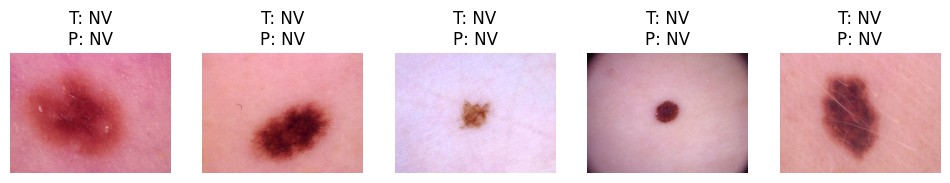

In [32]:
import matplotlib.pyplot as plt

samples = test_df.sample(5)

plt.figure(figsize=(12,6))

for i, (_, row) in enumerate(samples.iterrows()):
    img = cv2.imread(row['image_path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_resized = cv2.resize(img, (224,224))
    img_norm = img_resized.astype(np.float32)/255.0
    img_norm = (img_norm - IMAGENET_MEAN)/IMAGENET_STD
    img_norm = np.expand_dims(img_norm, axis=0)

    pred = model.predict(img_norm)
    pred_label = np.argmax(pred)

    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(
        f"T: {class_names[row['label']]}\n"
        f"P: {class_names[pred_label]}"
    )

plt.show()

In [33]:
import tensorflow as tf
import matplotlib.cm as cm

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


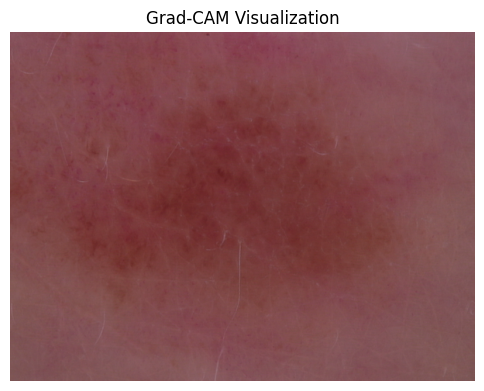

In [34]:
# Prepare image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (224,224))
img_norm = img_resized.astype(np.float32)/255.0
img_norm = (img_norm - IMAGENET_MEAN)/IMAGENET_STD
img_input = np.expand_dims(img_norm, axis=0)

# Generate heatmap
heatmap = make_gradcam_heatmap(
    img_input,
    model,
    last_conv_layer_name="conv5_block32_concat"  # DenseNet169
)

# Overlay heatmap
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cm.jet(heatmap)[:, :, :3]
overlay = 0.4 * heatmap + 0.6 * img

plt.figure(figsize=(6,6))
plt.imshow(overlay.astype("uint8"))
plt.axis("off")
plt.title("Grad-CAM Visualization")
plt.show()

/tmp/ipython-input-1645473996.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1))


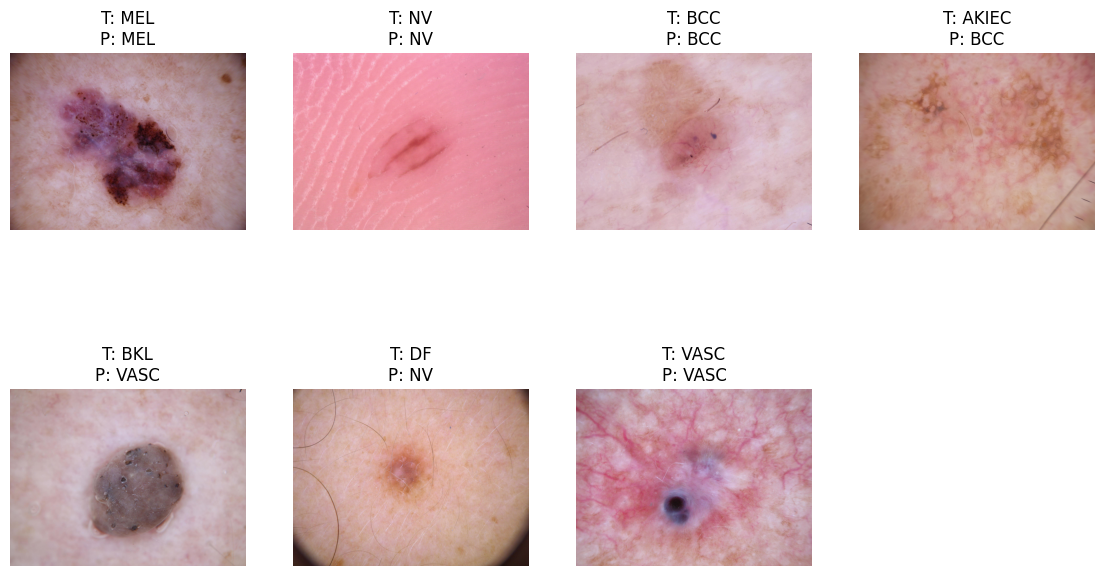

In [35]:
samples = (
    test_df
    .groupby('label', group_keys=False)
    .apply(lambda x: x.sample(1))
)

plt.figure(figsize=(14,8))

for i, (_, row) in enumerate(samples.iterrows()):
    img = cv2.imread(row['image_path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_resized = cv2.resize(img, (224,224))
    img_norm = img_resized.astype(np.float32)/255.0
    img_norm = (img_norm - IMAGENET_MEAN)/IMAGENET_STD
    img_norm = np.expand_dims(img_norm, axis=0)

    pred = model.predict(img_norm, verbose=0)
    pred_label = np.argmax(pred)

    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(
        f"T: {class_names[row['label']]}\n"
        f"P: {class_names[pred_label]}"
    )

plt.show()